In [3]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## MDS-MISIS-DL Car classification

### Classify car model based on its photo

https://www.kaggle.com/competitions/mds-misis-dl-car-classificationn

----


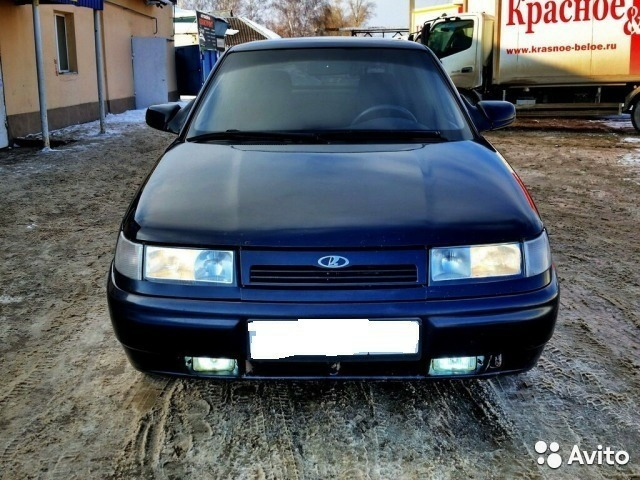

## Step 0: Prepare functionality for loading data


----


Provided dataset consists of two folder and one csv file. <br>
In the **train** folder there are train images, different sizes and color spaces (RGB and grayscale).
csv file contains labels for these images. <br>
In the **test** folder there are images, for which we shall predict labels.

---

In the cell below custom dataset class is defined:

In [5]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


class JpgDataset(Dataset):
    def __init__(self, images_dir: str, labels_csv='', transform=None):
        super(Dataset, self).__init__()
        self.transform = transform
        self.img_data = self.__read_images(images_dir)
        if labels_csv:
            self.labels = pd.read_csv(labels_csv)
        else:
            self.labels = None

    def __len__(self):
        return len(self.img_data)

    def __getlabel(self, img_name: str):
        if self.labels is not None:
            sample = self.labels[self.labels['Id'] == img_name]
            if not sample.empty:
                return sample.Category.values[0].item()
        return 0

    def __read_images(self, dir_name: str):
        img_data = []
        for img_name in os.listdir(dir_name):
            with Image.open(os.path.join(dir_name, img_name)).convert('RGB') as sample_image:

                img_data.append((img_name, np.asarray(sample_image)))
        return img_data

    def __getitem__(self, index):
        img_name, image = self.img_data[index]
        if self.transform is not None:
            image = self.transform(image)
        return img_name, image, self.__getlabel(img_name)


In [6]:
import torch
import gc
import os
from torchvision import transforms

# Dataset parameters
CLASS_NUM = 10
IMG_SIZE = 227
IMG_CHANNELS = 3

class PerImageNormalization(object):
    def __call__(self, tensor_image):
        """
        :param img: tensor

        :return: normalized tensor
        """
        mean, std = tensor_image.mean([1, 2]), tensor_image.std([1, 2])
        normalize = transforms.Normalize(mean=mean, std=std)
        return normalize(tensor_image)

    def __repr__(self):
        return self.__class__.__name__ + '()'

# It might be necessary to increase swap
# before loading whole training dataset: https://askubuntu.com/questions/178712/how-to-increase-swap-space
# with parameters bs=1024 count=136314880.
# It took around 100Gb of Swp
def create_dataset(root_dir, labels_csv='', train=True):
    image_transformation = transforms.Compose([
        transforms.ToPILImage(),  # Convert a tensor or a ndarray to PIL Image
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        PerImageNormalization()])

    if train:
        datasets = []
        for dir_name in os.listdir(root_dir):
            datasets.append(JpgDataset(os.path.join(root_dir, dir_name), labels_csv, image_transformation))
            print('Images from dir with label', dir_name, 'loaded.')

        return torch.utils.data.ConcatDataset(datasets)
    else:
        return JpgDataset(root_dir, labels_csv, image_transformation)

## Step 1: Design Model


----


For this challenge AlexNet architecture was used as well. It showed sufficient results and still not computationally too heavy. 

In [7]:
from torch.nn import Linear, Conv2d, MaxPool2d, Module, BatchNorm2d
import torch.nn.functional as functional


class AlexNet(Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = Conv2d(in_channels=3,
                            out_channels=96,
                            kernel_size=11,
                            stride=4,
                            padding=0)
        self.batchnorm1 = BatchNorm2d(96)
        self.maxpool = MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = Conv2d(in_channels=96,
                            out_channels=256,
                            kernel_size=5, stride=1,
                            padding=2)
        self.batchnorm2 = BatchNorm2d(256)

        self.conv3 = Conv2d(in_channels=256,
                            out_channels=384,
                            kernel_size=3,
                            stride=1,
                            padding=1)
        self.batchnorm3 = BatchNorm2d(384)

        self.conv4 = Conv2d(in_channels=384,
                            out_channels=384,
                            kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = BatchNorm2d(384)

        self.conv5 = Conv2d(in_channels=384,
                            out_channels=256,
                            kernel_size=3, stride=1, padding=1)
        self.batchnorm5 = BatchNorm2d(256)

        self.fc1 = Linear(in_features=9216,
                          out_features=4096)
        self.fc2 = Linear(in_features=4096,
                          out_features=4096)
        self.fc3 = Linear(in_features=4096, out_features=10)

    # Forward pass
    def forward(self, x):
        x = functional.relu(self.conv1(x.float()))
        x = self.batchnorm1(x)
        x = self.maxpool(x)

        x = functional.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)

        x = functional.relu(self.conv3(x))
        x = self.batchnorm3(x)

        x = functional.relu(self.conv4(x))
        x = self.batchnorm4(x)

        x = functional.relu(self.conv5(x))
        x = self.batchnorm5(x)
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)  # flatten
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Step 2: Predict on train data set


In [10]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np

class ModelLauncher:
    def __init__(self, device):
        self.model = AlexNet()
        self.device = device
        self.model = self.model.to(device=self.device)  # send the model for training on either cuda or cpu
        # Initialize learning parameters
        self.learning_rate = 1e-4
        self.epochs = 50
        self.criterion = CrossEntropyLoss()
        self.optimizer = Adam(self.model.parameters(), lr=self.learning_rate)
        self.batch_size = 64

    def train(self, torch_dataset, save_model=False):
        # Split to validation and train sets
        validation_set_size = int(0.2 * len(torch_dataset))
        train_set_size = len(torch_dataset) - validation_set_size

        train_subset, validation_subset = random_split(torch_dataset, [train_set_size, validation_set_size],
                                                       generator=torch.Generator().manual_seed(42))
        # Shuffle data both in train and validation sets
        train_dl = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
        val_dl = DataLoader(validation_subset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            loss_ep = 0
            for batch_idx, (_, data, targets) in enumerate(train_dl):
                data = data.to(device=self.device)
                targets = targets.to(device=self.device)
                ## Forward Pass
                self.optimizer.zero_grad()
                scores = self.model(data)
                loss = self.criterion(scores, targets)
                loss.backward()
                self.optimizer.step()
                loss_ep += loss.item()
            print(f"Loss in epoch {epoch} :::: {loss_ep / len(train_dl)}")

            with torch.no_grad():
                num_correct = 0
                num_samples = 0
                for batch_idx, (_, data, targets) in enumerate(val_dl):
                    data = data.to(device=self.device)
                    targets = targets.to(device=self.device)
                    ## Forward Pass
                    scores = self.model(data)
                    _, predictions = scores.max(1)
                    num_correct += (predictions == targets).sum()
                    num_samples += predictions.size(0)
                print(
                    f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
                )

            if save_model:
                torch.save(self.model.state_dict(), './model_from_last_train.pth')

    def predict(self, torch_dataset, model_from_file=''):
        if model_from_file:
            self.model.load_state_dict(torch.load(model_from_file))

        submission_dl = DataLoader(torch_dataset, batch_size=self.batch_size, shuffle=False)

        submission_results = []
        img_names_column = []
        for batch_idx, (img_names, data, _) in enumerate(submission_dl):
            ## Forward Pass
            scores = self.model(data.cuda())
            softmax = torch.exp(scores).cpu()
            prob = list(softmax.detach().numpy())
            predictions = np.argmax(prob, axis=1)
            submission_results.append(predictions)
            img_names_column.append(img_names)

        return submission_results, img_names_column


In [11]:
model_launcher = ModelLauncher(device)

train_dataset = create_dataset('data/train', 'data/train.csv')
model_launcher.train(train_dataset)

Images from dir with label 0 loaded.
Images from dir with label 7 loaded.
Images from dir with label 5 loaded.
Images from dir with label 3 loaded.
Images from dir with label 6 loaded.
Images from dir with label 1 loaded.
Images from dir with label 9 loaded.
Images from dir with label 8 loaded.
Images from dir with label 4 loaded.
Images from dir with label 2 loaded.


/home/nastya/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss in epoch 0 :::: 2.156754669165
Got 904 / 3112 with accuracy 29.05
Loss in epoch 1 :::: 1.631668190467052
Got 1395 / 3112 with accuracy 44.83
Loss in epoch 2 :::: 1.2038487574993035
Got 1682 / 3112 with accuracy 54.05
Loss in epoch 3 :::: 0.8908565282821655
Got 1896 / 3112 with accuracy 60.93
Loss in epoch 4 :::: 0.6585427560867407
Got 2007 / 3112 with accuracy 64.49
Loss in epoch 5 :::: 0.46389940778414407
Got 2063 / 3112 with accuracy 66.29
Loss in epoch 6 :::: 0.31419839343199363
Got 2150 / 3112 with accuracy 69.09
Loss in epoch 7 :::: 0.23953033762100415
Got 2089 / 3112 with accuracy 67.13
Loss in epoch 8 :::: 0.18013803135508147
Got 2169 / 3112 with accuracy 69.70
Loss in epoch 9 :::: 0.13458517597844968
Got 2166 / 3112 with accuracy 69.60
Loss in epoch 10 :::: 0.1056167535101756
Got 2215 / 3112 with accuracy 71.18
Loss in epoch 11 :::: 0.08025374082514108
Got 2085 / 3112 with accuracy 67.00
Loss in epoch 12 :::: 0.08496370919717428
Got 2215 / 3112 with accuracy 71.18
Loss in 

## Step 3: Predict on final data


In [12]:
dataset_for_submission = create_dataset('data/test', '', False)
submission_results, img_names_column = model_launcher.predict(dataset_for_submission)

In [13]:
submission_results = np.concatenate(submission_results)
img_names_column = np.concatenate(img_names_column)

In [52]:
# Visualize random sample and predicted label

import matplotlib.pyplot as plt
from random import randrange

iterator = iter(dataset_for_submission)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


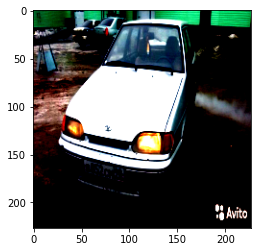

In [58]:
sample = next(iterator)
image = sample[1]
name = sample[0]
index = np.where(img_names_column == name)[0][0]
plt.imshow(image.permute(1, 2, 0))
print(submission_results[index])

### 3.0 Store predicted results to submission file

In [59]:
sample_submission = pd.read_csv('data/sample-submission.csv')
sample_submission['Category'] = submission_results
sample_submission['Id'] = img_names_column

sample_submission.to_csv('avtovaz_submission.csv', index=False)